In [1]:
import warnings
import os
from torch.utils.data import DataLoader
import torch.nn.functional as Fin
import timeit
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torchdiffeq import odeint as odeint
import matplotlib
matplotlib.use('Agg')
import argparse
import sys
import time
import torch
torch.manual_seed(42)
torch.cuda.empty_cache() 
import torch.optim as optim
import random
import logging
logging.propagate = False 
logging.getLogger().setLevel(logging.ERROR)
import sys
import wandb
import torch.nn.functional as F
import torch.nn as nn
import xarray as xr
from torchcubicspline import(natural_cubic_spline_coeffs, 
                             NaturalCubicSpline)

In [2]:
def my_gradient(data, dim) :
    # 10, 5, 32, 64
    # 10, 1, 5, 32, 64
    squeeze=False
    if data.dim() == 5:
        squeeze=True
        data = data.squeeze(1)
        dim = dim - 1
        
    if dim==2 :
        pad = nn.CircularPad2d((0,0,2,2))
    if dim==3 :
        pad = nn.CircularPad2d((2,2,0,0))
        
    out = pad(data)
    out = torch.gradient(out, dim=dim)[0]

    if dim==2 :
        out = out[:,:,2:-2,:]
    if dim==3 :
        out = out[:,:,:,2:-2]
    if squeeze :
        out = out.unsqueeze(1)
        
    return out, 

In [3]:
# from model_function import *
# from model_utils import *
# from utils import *

In [4]:
def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

def get_train_test_data_without_scales_batched_monthly(data_path,train_time_scale,val_time_scale,test_time_scale,lev,spectral):
    data = xr.open_mfdataset(data_path, combine='by_coords')
    if lev in ["v","u","r","q","tisr"]:
        data = data.sel(level=500)
    data = data.resample(time="6H").nearest(tolerance="1H") # Setting data to be 6-hour cycles
    data = data.resample(time="MS").mean()

    data_train = data.sel(time=train_time_scale).load()
    data_val = data.sel(time=val_time_scale).load()
    data_test = data.sel(time=test_time_scale).load()
    data_global = data.sel(time=slice('2006','2018')).load()

    max_val = data_global.max()[lev].values.tolist()
    min_val = data_global.min()[lev].values.tolist()

    data_train_final = (data_train - min_val)/ (max_val - min_val)
    data_val_final = (data_val - min_val)/ (max_val - min_val)
    data_test_final = (data_test - min_val)/ (max_val - min_val)

    time_vals = data_test_final.time.values
    train_times = [i for i in range(2006,2016)]
    test_times = [2017,2018]
    val_times = [2016]

    train_data = get_batched_monthly(train_times,data_train_final,lev)
    test_data = get_batched_monthly(test_times,data_test_final,lev)
    val_data = get_batched_monthly(val_times,data_val_final,lev)


    t = [i for i in range(12)]
    time_steps = torch.tensor(t).view(-1,1)

    return train_data,val_data,test_data,time_steps,data.lat.values,data.lon.values,max_val,min_val,time_vals


def get_batched_monthly(train_times,data_train_final,lev):
    for idx,year in enumerate(train_times):
        data_per_year = data_train_final.sel(time=slice(str(year),str(year))).load()
        data_values = data_per_year[lev].values
        t_data = torch.from_numpy(data_values).reshape(-1,1,1,data_values.shape[-2],data_values.shape[-1])
        if idx ==0:
            train_data = t_data
        else:
            train_data = torch.cat([train_data,t_data],dim=1)
    
    return train_data

def add_constant_info(path):
    print(path)
    data = xr.open_mfdataset(path, combine='by_coords')
    for idx,var in enumerate(['orography','lsm']):
        var_value = torch.from_numpy(data[var].values).view(1,1,32,64)
        if idx ==0: final_var = var_value
        else:
            final_var = torch.cat([final_var,var_value],dim=1)

    return final_var,torch.from_numpy(data['lat2d'].values),torch.from_numpy(data['lon2d'].values)

In [5]:
set_seed(42)
cwd = os.getcwd()
#data_path = {'z500':str(cwd) + '/era5_data/geopotential_500/*.nc','t850':str(cwd) + '/era5_data/temperature_850/*.nc'}
SOLVERS = ["dopri8","dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams',"adaptive_heun","euler"]
parser = argparse.ArgumentParser('ClimODE')
parser.add_argument('--solver', type=str, default="euler", choices=SOLVERS)
parser.add_argument('--atol', type=float, default=5e-3)
parser.add_argument('--rtol', type=float, default=5e-3)
parser.add_argument("--step_size", type=float, default=None, help="Optional fixed step size.")
parser.add_argument('--niters', type=int, default=2000)
parser.add_argument('--teacher', type=int, default=1,choices=[0,1])
parser.add_argument('--scale', type=int, default=0)
parser.add_argument('--days', type=int, default=3)
parser.add_argument('--batch_size', type=int, default=3)
parser.add_argument('--spectral', type=int, default=0,choices=[0,1])
parser.add_argument('--lr', type=float, default=0.0005)
parser.add_argument('--weight_decay', type=float, default=1e-5)
parser.add_argument('--loss_type', type=int, default=0,choices=[0,1])
args = parser.parse_args(args=[])


Random seed set as 42


In [11]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


train_time_scale= slice('2006','2016')
val_time_scale = slice('2016','2016')
test_time_scale = slice('2017','2018')

In [12]:
paths_to_data = [str(cwd) + '/era5_data/geopotential_500/*.nc',str(cwd) + '/era5_data/temperature_850/*.nc',str(cwd) + '/era5_data/2m_temperature/*.nc',str(cwd) + '/era5_data/10m_u_component_of_wind/*.nc',str(cwd) + '/era5_data/10m_v_component_of_wind/*.nc']
const_info_path = ['./era5_data/constants/constants_5.625deg.nc']#/scratch/project_2006852/PDE_climate
levels = ["z","t","t2m","u10","v10","v","u","r","q"]
paths_to_data = paths_to_data[0:5]
levels = levels[0:5]
assert len(paths_to_data) == len(levels), "Paths to different type of data must be same as number of types of observations"
print("############################ Data is loading ###########################")
Final_train_data = 0
Final_val_data = 0
Final_test_data = 0
max_lev = []
min_lev = []
for idx,data in enumerate(paths_to_data):
    Train_data,Val_data,Test_data,time_steps,lat,lon,mean,std,time_stamp = get_train_test_data_without_scales_batched_monthly(data,train_time_scale,val_time_scale,test_time_scale,levels[idx],args.spectral)  
    max_lev.append(mean)
    min_lev.append(std)
    if idx==0: 
        Final_train_data = Train_data
        Final_val_data = Val_data
        Final_test_data = Test_data
    else:
        Final_train_data = torch.cat([Final_train_data,Train_data],dim=2)
        Final_val_data = torch.cat([Final_val_data,Val_data],dim=2)
        Final_test_data = torch.cat([Final_test_data,Test_data],dim=2)

print("Length of training data",len(Final_train_data))
print("Length of validation data",len(Final_val_data))
print("Length of testing data",len(Final_test_data))
const_channels_info,lat_map,lon_map = add_constant_info(const_info_path)
if args.spectral == 1: print("############## Running the Model in Spectral Domain ####################")
H,W = Train_data.shape[3],Train_data.shape[4]
Train_loader = DataLoader(Final_train_data[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)
Val_loader = DataLoader(Final_val_data[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)
Test_loader = DataLoader(Final_test_data[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)
time_loader = DataLoader(time_steps[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)
time_idx_steps = torch.tensor([i for i in range(12)]).view(-1,1)
time_idx = DataLoader(time_idx_steps[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)


############################ Data is loading ###########################


/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/indexes.py:561: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tolerance=tolerance)
/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/groupby.py:668: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(
/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/xarray/core/indexes.py:561: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  flat_indexer = index.get_indexer(flat_labels, method=method, tol

Length of training data 12
Length of validation data 12
Length of testing data 12
['./era5_data/constants/constants_5.625deg.nc']


# Gradient

In [13]:
class Climate_encoder_free_uncertain_monthly(nn.Module): 
    
    def __init__(self,num_channels,const_channels,out_types,method,use_att,use_err,use_pos):
        super().__init__()
        self.layers = [4,3,2]
        self.hidden = [128,64,2*out_types]
        input_channels = 50 
        self.vel_f = Climate_ResNet_2D(input_channels,self.layers,self.hidden)

        if use_att: 
            self.vel_att = Self_attn_conv(input_channels,10)
            self.gamma = nn.Parameter(torch.tensor([0.1]))

        self.scales = num_channels
        self.const_channel = const_channels
        
        self.out_ch = out_types
        self.past_samples = 0
        self.const_info = 0
        self.lat_map = 0
        self.lon_map = 0
        self.elev = 0
        self.pos_emb = 0
        self.elev_info_grad_x = 0
        self.elev_info_grad_y = 0
        self.method = method
        err_in = 29
        if use_err: self.noise_net = Climate_ResNet_2D(err_in,[3,2,2],[128,64,2*out_types])
        if use_pos: self.pos_enc = Climate_ResNet_2D(4,[2,1,1],[32,16,out_types])
        self.att = use_att
        self.err = use_err
        self.pos = use_pos
        self.pos_feat = 0
        self.lsm =0 
        self.oro =0 


    def update_param(self, params):
        self.past_samples = params[0]
        self.const_info = params[1]
        self.lat_map = params[2]
        self.lon_map = params[3]

    def pde(self,t,vs):

        ds = vs[:,-self.out_ch:,:,:].float().view(-1,self.out_ch,vs.shape[2],vs.shape[3]).float()
        v = vs[:,:2*self.out_ch,:,:].float().view(-1,2*self.out_ch,vs.shape[2],vs.shape[3]).float()

        t_emb = ((t*100)%6).view(1,1,1,1).expand(ds.shape[0],1,ds.shape[2],ds.shape[3])
        sin_t_emb = torch.sin(torch.pi*t_emb/(12*6) - torch.pi/2)
        cos_t_emb = torch.cos(torch.pi*t_emb/(12*6)- torch.pi/2)
        

        day_emb = torch.cat([sin_t_emb,cos_t_emb],dim=1)

        ds_grad_x = my_gradient(ds,dim=3)[0]
        ds_grad_y = my_gradient(ds,dim=2)[0]
        nabla_u = torch.cat([ds_grad_x,ds_grad_y],dim=1)

        if self.pos:
            comb_rep = torch.cat([t_emb/6,day_emb,nabla_u,v,ds,self.pos_feat],dim=1)
        else:
            cos_lat_map,sin_lat_map = torch.cos(self.new_lat_map),torch.sin(self.new_lat_map)
            cos_lon_map,sin_lon_map = torch.cos(self.new_lon_map),torch.sin(self.new_lon_map)
            t_cyc_emb = day_emb
            pos_feats = torch.cat([cos_lat_map,cos_lon_map,sin_lat_map,sin_lon_map,sin_lat_map*cos_lon_map,sin_lat_map*sin_lon_map],dim=1)
            pos_time_ft = self.get_time_pos_embedding(t_cyc_emb,pos_feats)
            comb_rep = torch.cat([t_emb/6,day_emb,nabla_u,v,ds,self.new_lat_map,self.new_lon_map,self.lsm,self.oro,pos_feats,pos_time_ft],dim=1)

        if self.att: dv = self.vel_f(comb_rep) + self.gamma*self.vel_att(comb_rep)
        else: dv = self.vel_f(comb_rep)
        v_x = v[:,:self.out_ch,:,:].float().view(-1,self.out_ch,vs.shape[2],vs.shape[3]).float()
        v_y = v[:,-self.out_ch:,:,:].float().view(-1,self.out_ch,vs.shape[2],vs.shape[3]).float()

        adv1 = v_x*ds_grad_x + v_y*ds_grad_y
        adv2 = ds*(my_gradient(v_x,dim=3)[0] + my_gradient(v_y,dim=2)[0] )

        ds = adv1 + adv2

        dvs = torch.cat([dv,ds],1)
        return dvs
    
    

    def get_time_pos_embedding(self,time_feats,pos_feats):
        for idx in range(time_feats.shape[1]):
            tf = time_feats[:,idx].unsqueeze(dim=1)*pos_feats
            if idx == 0:
                final_out = tf
            else:
                final_out = torch.cat([final_out,tf],dim=1)

        return final_out

    def noise_net_contrib(self,t,pos_enc,s_final,noise_net,H,W):

        t_emb = (t%6).view(-1,1,1,1,1)
        sin_t_emb = torch.sin(torch.pi*t_emb/(12*6) - torch.pi/2).expand(len(s_final),s_final.shape[1],1,H,W)
        cos_t_emb = torch.cos(torch.pi*t_emb/(12*6) - torch.pi/2).expand(len(s_final),s_final.shape[1],1,H,W)
        

        pos_enc = pos_enc.expand(len(s_final),s_final.shape[1],-1,H,W).flatten(start_dim=0,end_dim=1)
        t_cyc_emb = torch.cat([sin_t_emb,cos_t_emb],dim=2).flatten(start_dim=0,end_dim=1)

        pos_time_ft = self.get_time_pos_embedding(t_cyc_emb,pos_enc[:,2:-2])

        comb_rep = torch.cat([t_cyc_emb,s_final.flatten(start_dim=0,end_dim=1),pos_enc,pos_time_ft],dim=1)
        final_out = noise_net(comb_rep).view(len(t),-1,2*self.out_ch,H,W)

        mean = s_final + final_out[:,:,:self.out_ch]
        std = nn.Softplus()(final_out[:,:,self.out_ch:])
        
        return mean,std


    def forward(self,T,data,atol=0.1,rtol=0.1):
        H,W = self.past_samples.shape[2],self.past_samples.shape[3]
        final_data = torch.cat([self.past_samples ,data.float().view(-1,self.out_ch,H,W)],1)
        init_time = T[0].item()*6
        final_time = T[-1].item()*6
        steps_val = final_time - init_time
        
        #breakpoint()

        if self.pos:
            lat_map = self.lat_map.unsqueeze(dim=0)*torch.pi/180
            lon_map = self.lon_map.unsqueeze(dim=0)*torch.pi/180
            pos_rep = torch.cat([lat_map.unsqueeze(dim=0),lon_map.unsqueeze(dim=0),self.const_info],dim=1)
            self.pos_feat = self.pos_enc(pos_rep).expand(data.shape[0],-1,data.shape[3],data.shape[4])
            final_pos_enc = self.pos_feat
        
        else:
            self.oro,self.lsm = self.const_info[0,0],self.const_info[0,1]
            self.lsm = self.lsm.unsqueeze(dim=0).expand(data.shape[0],-1,data.shape[3],data.shape[4])
            self.oro  = F.normalize(self.const_info[0,0]).unsqueeze(dim=0).expand(data.shape[0],-1,data.shape[3],data.shape[4])
            self.new_lat_map = self.lat_map.expand(data.shape[0],1,data.shape[3],data.shape[4])*torch.pi/180 # Converting to radians
            self.new_lon_map = self.lon_map.expand(data.shape[0],1,data.shape[3],data.shape[4])*torch.pi/180
            cos_lat_map,sin_lat_map = torch.cos(self.new_lat_map),torch.sin(self.new_lat_map)
            cos_lon_map,sin_lon_map = torch.cos(self.new_lon_map),torch.sin(self.new_lon_map)
            pos_feats = torch.cat([cos_lat_map,cos_lon_map,sin_lat_map,sin_lon_map,sin_lat_map*cos_lon_map,sin_lat_map*sin_lon_map],dim=1)
            final_pos_enc = torch.cat([self.new_lat_map,self.new_lon_map,pos_feats,self.lsm,self.oro],dim=1)


        new_time_steps = torch.linspace(init_time,final_time,steps=int(steps_val)+1).to(data.device)
        t = 0.01*new_time_steps.float().to(data.device).flatten().float()
        pde_rhs  = lambda t,vs: self.pde(t,vs) # make the ODE forward function
        final_result = odeint(pde_rhs,final_data,t,method=self.method,atol=atol,rtol=rtol)
        s_final = final_result[:,:,-self.out_ch:,:,:].view(len(t),-1,self.out_ch,H,W)

        if self.err:
            mean,std = self.noise_net_contrib(T,final_pos_enc,s_final[0:len(s_final):6],self.noise_net,H,W)

        else:
            s_final = s_final[0:len(s_final):6]

        return mean,std,s_final[0:len(s_final):6]

In [14]:
class Climate_ResNet_2D(nn.Module): 
    
    def __init__(self,num_channels,layers,hidden_size):
        super().__init__()
        layers_cnn = []
        activation_fns = []
        self.block = ResidualBlock
        self.inplanes = num_channels

        for idx in range(len(layers)):
            if idx ==0:
                layers_cnn.append(self.make_layer(self.block,num_channels,hidden_size[idx],layers[idx]))
            else:
                layers_cnn.append(self.make_layer(self.block,hidden_size[idx-1],hidden_size[idx],layers[idx]))
        
        self.layer_cnn = nn.ModuleList(layers_cnn)
        self.activation_cnn = nn.ModuleList(activation_fns)

    def make_layer(self,block,in_channels,out_channels,reps):
        layers = []
        layers.append(block(in_channels,out_channels))
        self.inplanes = out_channels
        for i in range(1, reps):  
              layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self,data):
        dx_final = data.float()
        for l,layer in enumerate(self.layer_cnn):
            dx_final = layer(dx_final)

                
        return dx_final
    
class ResidualBlock(nn.Module):

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        activation: str = "gelu",
        norm: bool = False,
        n_groups: int = 1,
    ):
        super().__init__()
        self.activation = nn.LeakyReLU(0.3)
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=0)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.drop = nn.Dropout(p=0.1)
        # If the number of input channels is not equal to the number of output channels we have to
        # project the shortcut connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv2d(in_channels, out_channels, kernel_size=(1, 1))
        else:
            self.shortcut = nn.Identity()

        if norm:
            self.norm1 = nn.GroupNorm(n_groups, in_channels)
            self.norm2 = nn.GroupNorm(n_groups, out_channels)
        else:
            self.norm1 = nn.Identity()
            self.norm2 = nn.Identity()

    def forward(self, x: torch.Tensor):
        # First convolution layer
        x_mod = F.pad(F.pad(x,(0,0,1,1),'reflect'),(1,1,0,0),'circular')
        h = self.activation(self.bn1(self.conv1(self.norm1(x_mod))))
        # Second convolution layer
        h = F.pad(F.pad(h,(0,0,1,1),'reflect'),(1,1,0,0),'circular')
        h = self.activation(self.bn2(self.conv2(self.norm2(h))))
        h = self.drop(h)
        # Add the shortcut connection and return
        return h + self.shortcut(x)


class Self_attn_conv(nn.Module):
    
    def __init__(self, in_channels,out_channels):
        super(Self_attn_conv, self).__init__()
        self.query = self._conv(in_channels,in_channels//8,stride=1)
        self.key = self.key_conv(in_channels,in_channels//8,stride=2)
        self.value = self.key_conv(in_channels,out_channels,stride=2)
        self.post_map = nn.Sequential(nn.Conv2d(out_channels,out_channels,kernel_size=(1,1),stride=1,padding=0))
        self.out_ch = out_channels

    def _conv(self,n_in,n_out,stride):
        return nn.Sequential(boundarypad(),nn.Conv2d(n_in,n_in//2,kernel_size=(3,3),stride=stride,padding=0),nn.LeakyReLU(0.3),boundarypad(),nn.Conv2d(n_in//2,n_out,kernel_size=(3,3),stride=stride,padding=0),nn.LeakyReLU(0.3),boundarypad(),nn.Conv2d(n_out,n_out,kernel_size=(3,3),stride=stride,padding=0))
    
    def key_conv(self,n_in,n_out,stride):
        return nn.Sequential(nn.Conv2d(n_in,n_in//2,kernel_size=(3,3),stride=stride,padding=0),nn.LeakyReLU(0.3),nn.Conv2d(n_in//2,n_out,kernel_size=(3,3),stride=stride,padding=0),nn.LeakyReLU(0.3),nn.Conv2d(n_out,n_out,kernel_size=(3,3),stride=1,padding=0))
    
    def forward(self, x):
        size = x.size()
        x = x.float()
        q,k,v = self.query(x).flatten(-2,-1),self.key(x).flatten(-2,-1),self.value(x).flatten(-2,-1)
        beta = F.softmax(torch.bmm(q.transpose(1,2), k), dim=1)
        o = torch.bmm(v, beta.transpose(1,2))
        o = self.post_map(o.view(-1,self.out_ch,size[-2],size[-1]).contiguous())
        return o

class boundarypad(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return F.pad(F.pad(input,(0,0,1,1),'reflect'),(1,1,0,0),'circular')


def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_gauss_kernel(shape,lat,lon):
    cwd = os.getcwd()
    rows,columns  = shape
    kernel = torch.zeros(shape[0]*shape[1],shape[0]*shape[1])
    pos = []
    for i in range(rows):
        for j in range(columns):
            pos.append([lat[i],lon[j]])

    for i in range(rows*columns):
        for j in range(rows*columns):
            dist = torch.sum((torch.tensor(pos[i]) - torch.tensor(pos[j]))**2)
            kernel[i][j] = torch.exp(-dist/(2*1*1))

    kernel_inv = torch.linalg.inv(kernel).numpy()
    np.save(str(cwd) +"/kernel.npy",kernel_inv)

In [15]:
num_years = len(range(2006,2016))
model = Climate_encoder_free_uncertain_monthly(len(paths_to_data),2,out_types=len(paths_to_data),method=args.solver,use_att=True,use_err=True,use_pos=False).to(device)
param = count_parameters(model)
optimizer = optim.AdamW(model.parameters(), lr=args.lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.niters)

best_loss = float('inf')
train_best_loss = float('inf')
best_epoch = float('inf')
print("############################ Data is loaded, Fitting the velocity #########################")

#get_gauss_kernel((32,64),lat,lon)
kernel = torch.from_numpy(np.load(str(cwd) +"/kernel.npy"))

############################ Data is loaded, Fitting the velocity #########################


/home/namkyeong/anaconda3/envs/clim_ode/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Gradient

In [16]:
class Optim_velocity(nn.Module):
    def __init__(self,num_years,H,W):
        super(Optim_velocity,self).__init__()
        self.v_x = torch.nn.Parameter(torch.randn(num_years,1,5,H,W))
        self.v_y = torch.nn.Parameter(torch.randn(num_years,1,5,H,W))

    def forward(self,data):
        #print('data size: ', data.size())
        u_y = my_gradient(data,dim=3)[0] # (H,W) --> (y,x)
        u_x = my_gradient(data,dim=4)[0]
        #print('self.v_y size: ', self.v_y.size())
        adv = self.v_x*u_x + self.v_y*u_y + data*(my_gradient(self.v_y,dim=3)[0] + my_gradient(self.v_x,dim=4)[0])
        out = adv
        return out,self.v_x,self.v_y 

In [17]:
def nll(mean,std,truth,lat,var_coeff):
    normal_lkl = torch.distributions.normal.Normal(mean, 1e-3 + std)
    lkl = - normal_lkl.log_prob(truth)
    loss_val = lkl.mean() + var_coeff*(std**2).sum()
    #loss_val = torch.mean(lkl,dim=(0,1,3,4))
    return loss_val

def get_delta_u(u_vel,t_steps):
    levels = ["z","t","t2m","u10","v10","tisr","v","u","r","q"]
    t = t_steps.flatten().float()*6
    title = {"z":"Geopotential","v10": "v component of wind at 10m","u10": "u component of wind at 10m","t2m": "Temperature at 2m","t": "Temperature at 850hPa pressure"}
    input_u_vel = u_vel.view(u_vel.shape[0],u_vel.shape[1],-1)
    coeffs = natural_cubic_spline_coeffs(t, input_u_vel)
    spline = NaturalCubicSpline(coeffs)
    point = t[-1]
    out = spline.derivative(point).view(-1,u_vel.shape[2],u_vel.shape[3],u_vel.shape[4])
    
    return out


def optimize_vel(num,data,delta_u,vel_model,kernel,H,W,steps=200):
    model = vel_model(num,H,W)
    optimizer = optim.Adam(model.parameters(),lr=2)
    best_loss = float('inf')
    loss_step = []
    out,v_x,v_y = model(data)
    for step in range(steps):
        optimizer.zero_grad()
        out,v_x,v_y = model(data)
        kernel_v_x = v_x.view(num,5,-1,1)
        kernel_v_y = v_y.view(num,5,-1,1)
        kernel_expand = kernel.expand(num,5,kernel.shape[0],kernel.shape[1])
        v_x_kernel  = torch.matmul(kernel_v_x.transpose(2,3), kernel_expand)
        final_x = torch.matmul(v_x_kernel, kernel_v_x).mean()
        v_y_kernel  = torch.matmul(kernel_v_y.transpose(2,3), kernel_expand)
        final_y = torch.matmul(v_y_kernel, kernel_v_y).mean() 
        vel_loss = nn.MSELoss()(delta_u,out.squeeze(dim=1)) + 0.0000001*(final_x + final_y)
        loss_step.append(vel_loss.item())
        if vel_loss.item() < best_loss:
            best_loss = vel_loss.item()
            final_vx = v_x
            final_vy = v_y
            final_out = out
        vel_loss.backward()
        optimizer.step()
    print(best_loss)
    return final_vx,final_vy,loss_step,final_out



def fit_velocity(time_idx,time_loader,Final_train_data,data_loader,device,num_years,paths_to_data,scale,H,W,types,vel_model,kernel,lat,lon):
    num =0
    cwd = os.getcwd() 
    for idx_steps,time_steps,batch in zip(time_idx,time_loader,data_loader):
        pst = [time_steps[0].item()-i for i in range(3)]
        pst.reverse()
        pst_idx = [idx_steps[0].item()-i for i in range(3)]
        pst_idx.reverse()
        past_time = torch.tensor(pst).to(device)
        data = batch[0].to(device).view(num_years,1,len(paths_to_data)*(scale+1),H,W)
        past_sample = [Final_train_data[j].view(num_years,-1,len(paths_to_data)*(scale+1),H,W) for j in pst_idx]
        past_sample = torch.stack(past_sample).view(num_years,3,-1,H,W).to(device)
        delta_u = get_delta_u(past_sample,past_time)
        v_x,v_y,loss_terms,out = optimize_vel(num_years,data,delta_u,vel_model,kernel,H,W)
        final_v = torch.cat([v_x,v_y],dim=1).unsqueeze(dim=0)
        if num == 0:
            Final_v = final_v
        else:
            Final_v = torch.cat([Final_v,final_v],dim=0)
        num = num+1

    if os.path.exists(str(cwd) +"/" + types + "_vel_gradient_modified_pad2.npy"):
        os.remove(str(cwd) +"/" + types + "_vel_gradient_modified_pad2.npy")

    np.save(str(cwd) +"/" + types + "_vel_gradient_modified_pad2.npy",Final_v.detach().numpy())
    
def load_velocity(types):
    cwd = os.getcwd()
    vel = []
    for file in types:
        vel.append(np.load(str(cwd) + "/" + file + "_vel_gradient_modified_pad2.npy"))

    return (torch.from_numpy(v) for v in vel)

In [18]:
fit_velocity(time_idx,time_loader,Final_train_data,Train_loader,torch.device('cpu'),num_years,paths_to_data,args.scale,H,W,types='train_monthly',vel_model=Optim_velocity,kernel=kernel,lat=lat,lon=lon)
fit_velocity(time_idx,time_loader,Final_val_data,Val_loader,torch.device('cpu'),1,paths_to_data,args.scale,H,W,types='val_monthly',vel_model=Optim_velocity,kernel=kernel,lat=lat,lon=lon)
fit_velocity(time_idx,time_loader,Final_test_data,Test_loader,torch.device('cpu'),2,paths_to_data,args.scale,H,W,types='test_monthly',vel_model=Optim_velocity,kernel=kernel,lat=lat,lon=lon)

vel_train,vel_val = load_velocity(['train_monthly','val_monthly'])
print("############################ Velocity loaded, Model starts to train #########################")
print(model)
print("####################### Total Parameters",param ,"################################")
model.train()

0.00010985916742356494
0.00012452260125428438
0.00012279355723876506
0.0001097428539651446
0.00011757302127080038
0.00012433766096364707
0.00013300417049322277
0.00010905724775511771
0.00010988103895215318
0.00012234605674166232
0.00012229949061293155
0.00011406275007175282
############################ Velocity loaded, Model starts to train #########################
Climate_encoder_free_uncertain_monthly(
  (vel_f): Climate_ResNet_2D(
    (layer_cnn): ModuleList(
      (0): Sequential(
        (0): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (conv1): Conv2d(50, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
          (shortcut): Conv2d(50, 128, kern

Climate_encoder_free_uncertain_monthly(
  (vel_f): Climate_ResNet_2D(
    (layer_cnn): ModuleList(
      (0): Sequential(
        (0): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (conv1): Conv2d(50, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
          (shortcut): Conv2d(50, 128, kernel_size=(1, 1), stride=(1, 1))
          (norm1): Identity()
          (norm2): Identity()
        )
        (1): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2)

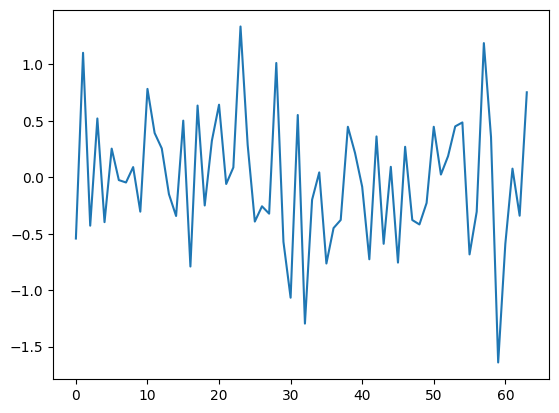

In [19]:
%matplotlib inline
plt.plot(vel_train[0,0,0,0,8,:])
plt.show()

In [20]:
for epoch in range(args.niters):
    total_train_loss = 0
    val_loss = 0
    test_loss = 0
    if epoch == 0:
        var_coeff = 0.001
    else:
        var_coeff = 2*scheduler.get_last_lr()[0]
    
    for entry,(time_steps,batch) in enumerate(zip(time_loader,Train_loader)):
        optimizer.zero_grad()
        data = batch[0].to(device).view(num_years,1,len(paths_to_data)*(args.scale+1),H,W)
        past_sample = vel_train[entry].view(num_years,2*len(paths_to_data)*(args.scale+1),H,W).to(device)
        model.update_param([past_sample,const_channels_info.to(device),lat_map.to(device),lon_map.to(device)])
        t = time_steps.float().to(device).flatten()
       
        mean,std,_ = model(t,data)
            
        loss = nll(mean,std,batch.float().to(device),lat,var_coeff)
            
        l2_lambda = 0.001
        l2_norm = sum(p.pow(2.0).sum()
                for p in model.parameters())
        loss = loss + l2_lambda * l2_norm
        loss.backward()
        optimizer.step()    
        print("Loss for batch is ",loss.item())
        if torch.isnan(loss) : 
            print("Quitting due to Nan loss")
            quit()
        total_train_loss = total_train_loss + loss.item()

    lr_val = scheduler.get_last_lr()[0]
    scheduler.step()
   
    print("|Iter ",epoch," | Total Train Loss ", total_train_loss,"|")
        

    for entry,(time_steps,batch) in enumerate(zip(time_loader,Val_loader)):
        data = batch[0].to(device).view(1,1,len(paths_to_data)*(args.scale+1),H,W)
        past_sample = vel_val[entry].view(1,2*len(paths_to_data)*(args.scale+1),H,W).to(device)
        model.update_param([past_sample,const_channels_info.to(device),lat_map.to(device),lon_map.to(device)])
        t = time_steps.float().to(device).flatten()
         
        mean,std,_ = model(t,data)
               
        loss = nll(mean,std,batch.float().to(device),lat,var_coeff)
        if torch.isnan(loss) : 
            print("Quitting due to Nan loss")
            quit()
      
        print("Val Loss for batch is ",loss.item())
        val_loss = val_loss + loss.item()

    print("|Iter ",epoch," | Total Val Loss ", val_loss,"|")



    if val_loss < best_loss:
        best_loss = val_loss
        best_epoch = epoch
        torch.save(model,str(cwd) + "/Models/gradient_modified/" + "ClimODE_monthly_avg_"+args.solver+"_"+str(args.spectral)+"_model_pad2.pt")

    if total_train_loss < train_best_loss:
        train_best_loss = total_train_loss
        torch.save(model,str(cwd) + "/Models/gradient_modified/" + "ClimODE_monthly_avg_overfit_"+args.solver+"_"+str(args.spectral)+"_model_pad2_" + str(epoch) + ".pt")


OutOfMemoryError: CUDA out of memory. Tried to allocate 32.00 MiB. GPU 0 has a total capacity of 23.64 GiB of which 4.44 MiB is free. Process 2968803 has 4.49 GiB memory in use. Process 3586360 has 9.48 GiB memory in use. Process 3620341 has 504.00 MiB memory in use. Process 3652729 has 2.26 GiB memory in use. Including non-PyTorch memory, this process has 6.88 GiB memory in use. Of the allocated memory 6.22 GiB is allocated by PyTorch, and 200.85 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

# Eval

In [21]:
set_seed(42)
SOLVERS = ["dopri8","dopri5", "bdf", "rk4", "midpoint", 'adams', 'explicit_adams', 'fixed_adams',"adaptive_heun"]
parser = argparse.ArgumentParser('ClimODE')
parser.add_argument('--solver', type=str, default="euler", choices=SOLVERS)
parser.add_argument('--atol', type=float, default=5e-3)
parser.add_argument('--rtol', type=float, default=5e-3)
parser.add_argument('--batch_size', type=int, default=3)
parser.add_argument("--step_size", type=float, default=None, help="Optional fixed step size.")
parser.add_argument('--teacher', type=int, default=1,choices=[0,1])
parser.add_argument('--scale', type=int, default=0)
parser.add_argument('--days', type=int, default=3)
parser.add_argument('--spectral', type=int, default=0,choices=[0,1])
args = parser.parse_args(args=[])

Random seed set as 42


In [22]:
cwd = os.getcwd()
train_time_scale= slice('2006','2016')
val_time_scale = slice('2016','2016')
test_time_scale = slice('2017','2018')

paths_to_data = [str(cwd) + '/era5_data/geopotential_500/*.nc',str(cwd) + '/era5_data/temperature_850/*.nc',str(cwd) + '/era5_data/2m_temperature/*.nc',str(cwd) + '/era5_data/10m_u_component_of_wind/*.nc',str(cwd) + '/era5_data/10m_v_component_of_wind/*.nc']
const_info_path = [str(cwd) + '/era5_data/constants/constants_5.625deg.nc']
levels = ["z","t","t2m","u10","v10","v","u","r","q"]
paths_to_data = paths_to_data[0:5]
levels = levels[0:5]
assert len(paths_to_data) == len(levels), "Paths to different type of data must be same as number of types of observations"
print("############################ Data is loading ###########################")
Final_train_data = 0
Final_val_data = 0
Final_test_data = 0
max_lev = []
min_lev = []
for idx,data in enumerate(paths_to_data):
    Train_data,Val_data,Test_data,time_steps,lat,lon,mean,std,time_stamp = get_train_test_data_without_scales_batched_monthly(data,train_time_scale,val_time_scale,test_time_scale,levels[idx],args.spectral)  
    max_lev.append(mean)
    min_lev.append(std)
    if idx==0: 
        Final_train_data = Train_data
        Final_val_data = Val_data
        Final_test_data = Test_data
    else:
        Final_train_data = torch.cat([Final_train_data,Train_data],dim=2)
        Final_val_data = torch.cat([Final_val_data,Val_data],dim=2)
        Final_test_data = torch.cat([Final_test_data,Test_data],dim=2)

print("Length of training data",len(Final_train_data))
print("Length of validation data",len(Final_val_data))
print("Length of testing data",len(Final_test_data))
const_channels_info,lat_map,lon_map = add_constant_info(const_info_path)

if args.spectral == 1: print("############## Running the Model in Spectral Domain ####################")
H,W = Train_data.shape[3],Train_data.shape[4]
clim = torch.mean(Final_test_data,dim=0)
Test_loader = DataLoader(Final_test_data[2:],batch_size=args.batch_size,shuffle=False)
time_loader = DataLoader(time_steps[2:],batch_size=args.batch_size,shuffle=False)
time_idx_steps = torch.tensor([i for i in range(12)]).view(-1,1)
time_idx = DataLoader(time_idx_steps[2:],batch_size=args.batch_size,shuffle=False,pin_memory=False)

otal_time_len = len(time_steps[2:])
total_time_steps = time_steps[2:].numpy().flatten().tolist()
num_years  = 2

vel_test= torch.from_numpy(np.load('test_monthly_vel_gradient_modified.npy'))
model = torch.load(str(cwd) + "/Models/gradient_modified/ClimODE_monthly_avg_euler_0_model_pad2.pt",map_location=torch.device('cpu')).to(device)
print(model)

############################ Data is loading ###########################
Length of training data 12
Length of validation data 12
Length of testing data 12
['/home/user/ClimODE/era5_data/constants/constants_5.625deg.nc']
Climate_encoder_free_uncertain_monthly(
  (vel_f): Climate_ResNet_2D(
    (layer_cnn): ModuleList(
      (0): Sequential(
        (0): ResidualBlock(
          (activation): LeakyReLU(negative_slope=0.3)
          (conv1): Conv2d(50, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop): Dropout(p=0.1, inplace=False)
          (shortcut): Conv2d(50, 128, kernel_size=(1, 1), stride=(1, 1))
          (norm1): Identity()
          (norm2): Identity()
        )
        (1): ResidualBlock(
          (activatio

In [23]:
def evaluation_rmsd_mm(Pred,Truth,lat,lon,max_vals,min_vals,H,W,levels):
    RMSD_final = []
    RMSD_lat_lon = []
    true_lat_lon = []
    pred_lat_lon = []
    for idx,lev in enumerate(levels):
        true_idx = idx
        das_pred = []
        das_true = []
        pred_spectral = Pred[idx].detach().cpu().numpy()
        true_spectral = Truth[true_idx,:,:].detach().cpu().numpy()

        pred = pred_spectral*(max_vals[idx] - min_vals[idx]) + min_vals[idx]

        das_pred.append(xr.DataArray(pred.reshape(1,H,W),dims=['time','lat','lon'],coords={'time':[0],'lat':lat,'lon':lon},name=lev))
        Pred_xr = xr.merge(das_pred)
        
        true = true_spectral*(max_vals[idx] - min_vals[idx]) + min_vals[idx]

        das_true.append(xr.DataArray(true.reshape(1,H,W),dims=['time','lat','lon'],coords={'time':[0],'lat':lat,'lon':lon},name=lev))
        True_xr = xr.merge(das_true)
        error = Pred_xr - True_xr
        weights_lat = np.cos(np.deg2rad(error.lat))
        weights_lat /= weights_lat.mean()
        rmse = np.sqrt(((error)**2 * weights_lat).mean(dim=['lat','lon'])).mean(dim=['time'])
        lat_lon_rmse = np.sqrt((error)**2)
        RMSD_lat_lon.append(lat_lon_rmse[lev].values)
        RMSD_final.append(rmse[lev].values.tolist())

    return RMSD_final


def evaluation_acc_mm(Pred,Truth,lat,lon,max_vals,min_vals,H,W,levels,clim):
    ACC_final = []
    
    for idx,lev in enumerate(levels):
        pred_spectral = Pred[idx].detach().cpu().numpy()
        true_spectral = Truth[idx,:,:].detach().cpu().numpy()
        pred_spectral = pred_spectral - clim[idx]
        true_spectral = true_spectral - clim[idx]

        pred = pred_spectral*(max_vals[idx] - min_vals[idx]) + min_vals[idx]
        true = true_spectral*(max_vals[idx] - min_vals[idx]) + min_vals[idx]

        weights_lat = np.cos(np.deg2rad(lat))
        weights_lat /= weights_lat.mean()
        weights_lat = weights_lat.reshape(len(lat),1)
        weights_lat = weights_lat.repeat(len(lon),1)

        pred_prime = pred - np.mean(pred)
        true_prime = true - np.mean(true)

        acc= np.sum(weights_lat * pred_prime * true_prime) / np.sqrt(np.sum(weights_lat * pred_prime**2) * np.sum(weights_lat * true_prime**2))
        ACC_final.append(acc)                                                        

    
    return ACC_final

In [24]:
RMSD = []
RMSD_lat_lon= []
Pred = []
Truth  = []

org_time = 1
RMSD = []
RMSD_lat_lon= []
Mean_pred = 0
Truth_pred = 0
Std_pred = 0
Lead_RMSD_arr = {"z":[[] for _ in range(args.batch_size-1)],"t":[[] for _ in range(args.batch_size-1)],"t2m":[[] for _ in range(args.batch_size-1)],"u10":[[] for _ in range(args.batch_size-1)],"v10":[[] for _ in range(args.batch_size-1)]}
Lead_ACC = {"z":[[] for _ in range(args.batch_size-1)],"t":[[] for _ in range(args.batch_size-1)],"t2m":[[] for _ in range(args.batch_size-1)],"u10":[[] for _ in range(args.batch_size-1)],"v10":[[] for _ in range(args.batch_size-1)]}
Lead_CRPS = {"z":[[] for _ in range(args.batch_size-1)],"t":[[] for _ in range(args.batch_size-1)],"t2m":[[] for _ in range(args.batch_size-1)],"u10":[[] for _ in range(args.batch_size-1)],"v10":[[] for _ in range(args.batch_size-1)]}
for entry,(time_steps,batch) in enumerate(zip(time_loader,Test_loader)):
        data = batch[0].to(device).view(num_years,1,len(paths_to_data)*(args.scale+1),H,W)
        past_sample = vel_test[entry].view(num_years,2*len(paths_to_data)*(args.scale+1),H,W).to(device)
        model.update_param([past_sample,const_channels_info.to(device),lat_map.to(device),lon_map.to(device)])
        t = time_steps.float().to(device).flatten()
        mean_pred,std_pred,_ = model(t,data)

        mean_avg = mean_pred.view(-1,len(paths_to_data)*(args.scale+1),H,W)
        std_avg = std_pred.view(-1,len(paths_to_data)*(args.scale+1),H,W)

        for yr in range(2): 
            for t_step in range(1,len(time_steps),1):
                evaluate_rmsd = evaluation_rmsd_mm(mean_pred[t_step,yr,:,:,:].cpu(),batch[t_step,yr,:,:,:].cpu(),lat,lon,max_lev,min_lev,H,W,levels)
                evaluate_acc = evaluation_acc_mm(mean_pred[t_step,yr,:,:,:].cpu(),batch[t_step,yr,:,:,:].cpu(),lat,lon,max_lev,min_lev,H,W,levels,clim[yr,:,:,:].cpu().detach().numpy())
                

                for idx,lev in enumerate(levels):
                    Lead_RMSD_arr[lev][t_step-1].append(evaluate_rmsd[idx]) 
                    Lead_ACC[lev][t_step-1].append(evaluate_acc[idx])

for t_idx in range(args.batch_size-1):
    for idx, lev in enumerate(levels):
        print("Lead Time ",(t_idx+1), "Month ","| Observable ",lev, "| Mean RMSD ", np.mean(Lead_RMSD_arr[lev][t_idx]), "| Std RMSD ", np.std(Lead_RMSD_arr[lev][t_idx]))
        #print("Lead Time ",(t_idx+1), "Month ","| Observable ",lev, "| Mean ACC ", np.mean(Lead_ACC[lev][t_idx]), "| Std ACC ", np.std(Lead_ACC[lev][t_idx]))

Lead Time  1 Month  | Observable  z | Mean RMSD  667.4801661120458 | Std RMSD  65.68050684159904
Lead Time  1 Month  | Observable  t | Mean RMSD  3.945515778566841 | Std RMSD  0.2238767244256872
Lead Time  1 Month  | Observable  t2m | Mean RMSD  4.606825997860753 | Std RMSD  0.9321288422691408
Lead Time  1 Month  | Observable  u10 | Mean RMSD  1.8539684160267331 | Std RMSD  0.11475372760710827
Lead Time  1 Month  | Observable  v10 | Mean RMSD  1.4946187937218898 | Std RMSD  0.07249561738691195
Lead Time  2 Month  | Observable  z | Mean RMSD  766.8315224885924 | Std RMSD  115.88155637124873
Lead Time  2 Month  | Observable  t | Mean RMSD  4.653784152374032 | Std RMSD  0.16712892814541927
Lead Time  2 Month  | Observable  t2m | Mean RMSD  5.61701836037956 | Std RMSD  0.8394289924268052
Lead Time  2 Month  | Observable  u10 | Mean RMSD  1.9625362763363814 | Std RMSD  0.07904978606343234
Lead Time  2 Month  | Observable  v10 | Mean RMSD  1.6333050656179058 | Std RMSD  0.12918983185078786


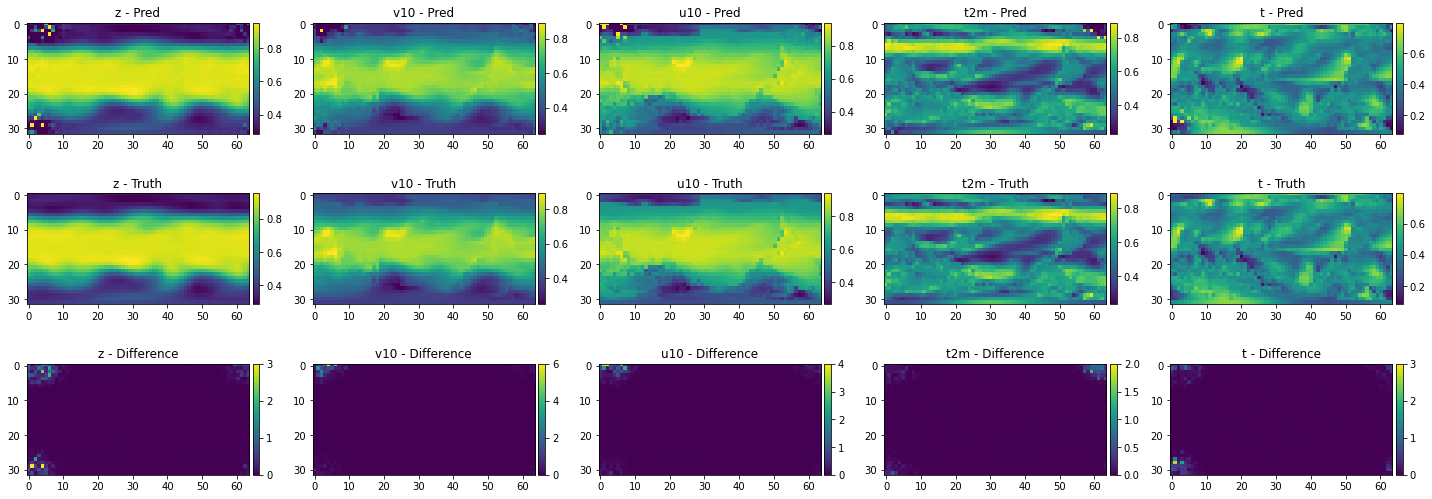

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np

mean_pred_np = mean_pred[0][0].cpu().detach().numpy()
batch_np = batch[0][0].cpu().detach().numpy()

titles = ["z", "v10", "u10", "t2m", "t"]

# Create a figure with 5 columns and 3 rows of subplots (Prediction, Truth, and Difference)
fig, axes = plt.subplots(3, 5, figsize=(20, 12))

# Reduce spacing between images, with smaller hspace to shorten the vertical space between rows
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# Plot each variable (z, v10, u10, t2m, t)
vmax_list = [3,6,4,2,3]
for i in range(5):
    vmin = batch_np[i].min()
    vmax = batch_np[i].max()
    
    # Top row (Prediction)
    ax1 = axes[0, i]
    im1 = ax1.imshow(mean_pred_np[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax1.set_title(f"{titles[i]} - Pred")
    
    # Add a small colorbar next to the top row images
    divider1 = make_axes_locatable(ax1)
    cax1 = divider1.append_axes("right", size="3%", pad=0.05)  # Make the colorbar smaller
    fig.colorbar(im1, cax=cax1, orientation='vertical')

    # Middle row (Truth)
    ax2 = axes[1, i]
    im2 = ax2.imshow(batch_np[i], cmap='viridis', vmin=vmin, vmax=vmax)
    ax2.set_title(f"{titles[i]} - Truth")
    
    # Add a small colorbar next to the middle row images
    divider2 = make_axes_locatable(ax2)
    cax2 = divider2.append_axes("right", size="3%", pad=0.05)  # Make the colorbar smaller
    fig.colorbar(im2, cax=cax2, orientation='vertical')

    # Bottom row (Difference)
    difference = (mean_pred_np[i] - batch_np[i])/batch_np[i]
    ax3 = axes[2, i]
    im3 = ax3.imshow(np.abs(difference), cmap='viridis', vmin=0, vmax=vmax_list[i])#
    ax3.set_title(f"{titles[i]} - Difference")

    # Add a small colorbar next to the bottom row images
    divider3 = make_axes_locatable(ax3)
    cax3 = divider3.append_axes("right", size="3%", pad=0.05)  # Make the colorbar smaller
    fig.colorbar(im3, cax=cax3, orientation='vertical')

plt.tight_layout()
plt.show()
